In [1]:
# Prepare model, data pre-processors and coordinate scalers

import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

from tensorflow import keras

import joblib

import sys
sys.path.insert(0, '/home/miguel/Projects/smlm_z/publication/')
from util.util import grid_psfs, load_dataset, save_dataset, load_model, preprocess_img_dataset

from tifffile import imread
import numpy as np

# model_result_dir = '/home/miguel/Projects/smlm_z/autofocus/VIT_autofocus/out_roll_alignment'
# test_data_dir = '/home/miguel/Projects/data/08042024_beads4Miguel/ROI2_timelapse_30_1min_1'
# test_case = 'ROI2_timelapse_30_1min_1_MMStack_Default.ome.tif'

# model_result_dir = '/home/miguel/Projects/smlm_z/autofocus/VIT_autofocus2/out_roll_alignment'
# test_data_dir = '/home/miguel/Projects/data/11042024_beads4Miguel/ROI10_TIMELAPSE_61count_1min_1/'
# test_case = 'ROI10_TIMELAPSE_61count_1min_1_MMStack_Default.ome.tif'

# model_result_dir = '/home/miguel/Projects/smlm_z/autofocus/VIT_openframe_20240510/out'
# test_data_dir = '/media/Backup/smlm_z_data/20240510_Miguel_beads/zstacks/100nm_tetraspeck/timelapse_1hr_1sec_interval_1'
# test_case = 'timelapse_1hr_1sec_interval_1_MMStack_Default.ome.tif'
# comparison_data = '/home/miguel/Projects/data/20240415_beads_AF_Miguel/autofocus.csv'
# PIXEL_SIZE = 106

# model_result_dir = '/home/miguel/Projects/smlm_z/autofocus/VIT_openframe_20240510_20nm_tmp/out'
# test_data_dir = '/media/Backup/smlm_z_data/20240510_Miguel_beads/zstacks/20nm_red/timelapse_1hr_1sec_1/'
# test_case = 'timelapse_1hr_1sec_1_MMStack_Default.ome.tif'
# comparison_data = '/home/miguel/Projects/data/20240415_beads_AF_Miguel/autofocus.csv'
# PIXEL_SIZE = 118


# Experiment1
# model_result_dir = '/home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/'
# test_data_dir = '/media/Backup/smlm_z_data/20240603_Miguel_Zeiss_Stacks/timelapse_20nm_4/'
# test_case = 'timelapse_20nm_4_MMStack_Default.ome.tif'
# comparison_data = '/media/Backup/smlm_z_data/20240603_Miguel_Zeiss_Stacks/Z_list.txt'
# key_frame_locs = 'timelapse_20nm_4_MMStack_Default_slice.ome_locs.hdf5'
# out_fig_name = './autofocus_experiment1.png'
# PIXEL_SIZE = 106

# Experiment 2
model_result_dir = '/home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/'
test_data_dir = '/media/Backup/smlm_z_data/20240606_bacteria_Miguel_zeiss/15min_timelapse_20nm_red_beads_every_1sec_1/'
test_case = '15min_timelapse_20nm_red_beads_every_1sec_1_MMStack_Default.ome.tif'
comparison_data = '/media/Backup/smlm_z_data/20240606_bacteria_Miguel_zeiss/15min_timelapse_20nm_red_beads_every_1sec_1/Z_list.txt'
key_frame_locs = '15min_timelapse_20nm_red_beads_every_1sec_1_MMStack_Default_slice.ome_locs.hdf5'
out_fig_name = './autofocus_experiment2.png'
PIXEL_SIZE = 106


from PIL import Image
img = np.array(Image.open(os.path.join(test_data_dir, test_case)))
im_size_nm = np.array(img.shape) * PIXEL_SIZE


2024-08-27 10:49:50.508014: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-27 10:49:50.508037: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-27 10:49:50.508058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-27 10:49:50.513353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-27 10:49:51.132710: W tensorflow/compiler/

In [26]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import shutil
from localise_exp_sample import main as loc_exp_sample_main, preprocess_args

test_fpath = os.path.join(test_data_dir, test_case)

locs_path = test_fpath.replace('.tif', '_locs.hdf5')
spots_path = test_fpath.replace('.tif', '_spots.hdf5')
outdir_name = '_'.join(test_data_dir.split('/')[-2:])
outdir = os.path.join(model_result_dir, f'timelapse_{outdir_name}')
os.makedirs(outdir, exist_ok=True)
args = {
    'locs': locs_path,
    'spots': spots_path,
    'outdir': outdir,
    'model_dir': model_result_dir,
    'picked_locs': None,
    # 'norm': norm,
    'pixel_size': PIXEL_SIZE,
    'sensitivity': 1,
    'gain': 1,
    'baseline': 100
}
args = preprocess_args(args)
loc_exp_sample_main(args)

locs_path = os.path.join(args['outdir'], 'locs_3d.hdf5')
locs = pd.read_hdf(locs_path, key='locs')
print('Loading', locs_path)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using model dir from parameter -mo/--model-dir
/media/Backup/smlm_z_data/20240606_bacteria_Miguel_zeiss/15min_timelapse_20nm_red_beads_every_1sec_1/15min_timelapse_20nm_red_beads_every_1sec_1_MMStack_Default.ome_locs.yaml
fov-max
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


  3%|██████▍                                                                                                                                                                                              | 617/18900 [01:27<43:26,  7.01it/s]


(37662, 12) (37662, 15, 15)
Gen 2d plot
Gen example splots
Applying pre-processing
Coords value range: -0.007938174 0.9910657
19/19 [==============================] - 1s 21ms/step
Wrote results to:
	- /home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/timelapse_15min_timelapse_20nm_red_beads_every_1sec_1_/locs_3d.hdf5
	- /home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/timelapse_15min_timelapse_20nm_red_beads_every_1sec_1_/locs_3d.yaml
Loading /home/miguel/Projects/smlm_z/publication/models/zeiss_red_beads/out_24_nvidia6/timelapse_15min_timelapse_20nm_red_beads_every_1sec_1_/locs_3d.hdf5


/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'z [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'x [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/home/miguel/anaconda3/envs/smlm_z/lib/python3.11/site-packages/tables/path.py:137: NaturalNameWarning: object name is not a valid Python identifier: 'y [nm]'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this obje

In [27]:
import h5py

with h5py.File(spots_path, 'r') as f:
    spots = np.array(f['spots'])


In [4]:
mean_spot_sum = spots.sum(axis=(1,2)).mean()

for i in range(spots.shape[0]):
    img = spots[i] / spots[i].sum()
    img *= mean_spot_sum
    spots[i] = img

In [7]:
with h5py.File(spots_path, 'w') as f:
    f.create_dataset('spots', data=spots)
print(spots_path)

/media/Backup/smlm_z_data/20240606_bacteria_Miguel_zeiss/15min_timelapse_20nm_red_beads_every_1sec_1/15min_timelapse_20nm_red_beads_every_1sec_1_MMStack_Default.ome_spots.hdf5


In [12]:
%matplotlib inline

(21, 12) (18900, 20)


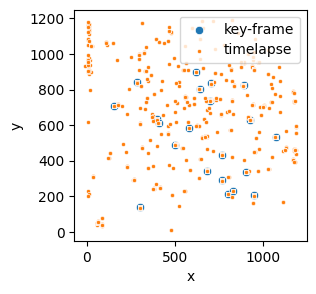

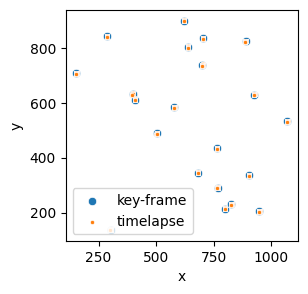

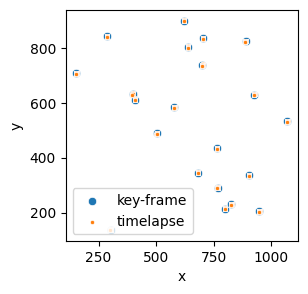

(21, 12)
(18900, 20)
Kept 18900 from 18900


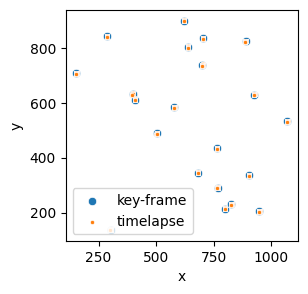

(18900, 20) (18900, 15, 15)


In [13]:
# Filter timelapse locs so only those in key frame are kept
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import euclidean_distances

def snr(x):
    return x.max() / x.mean()
    
key_frame_df = pd.read_hdf(os.path.join(test_data_dir, key_frame_locs), key='locs')
key_frame_df = key_frame_df[key_frame_df['net_gradient']>35000]
print(key_frame_df.shape, locs.shape)
plt.figure(figsize=(3,3))
sns.scatterplot(data=key_frame_df, x='x', y='y', label='key-frame')
sns.scatterplot(data=locs, x='x', y='y', label='timelapse', marker='.')
plt.legend()
plt.show()
print(key_frame_df.shape)
print(locs.shape)

locs_xy = locs[['x', 'y']].to_numpy()
key_frame_xy = key_frame_df[['x', 'y']].to_numpy()

dists = euclidean_distances(locs_xy, key_frame_xy)
threshold = 5

idx = np.argwhere(dists.min(axis=1)<threshold)[:, 0]
print(f'Kept {len(idx)} from {locs.shape[0]}')
locs = locs.iloc[idx]
spots = spots[idx]
locs['spot_id'] = np.arange(spots.shape[0])

locs['closest_key_loc'] = dists[idx].argmin(axis=1).astype(str)

locs['snr'] = [snr(x) for x in spots]

bg = spots.min()

locs['photons_no_background'] = [x.sum() - bg for x in spots]

plt.figure(figsize=(3,3))
sns.scatterplot(data=key_frame_df, x='x', y='y', label='key-frame')
sns.scatterplot(data=locs, x='x', y='y', label='timelapse', marker='.')
plt.legend()
plt.show()
print(locs.shape, spots.shape)

Text(0, 0.5, 'Number of beads in frame')

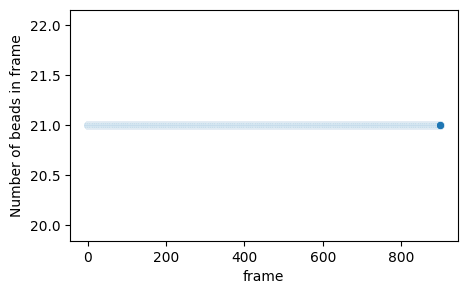

In [14]:
plt.figure(figsize=(5,3))
df2 = locs.groupby('frame').count()
sns.scatterplot(data=df2, x='frame', y='z [nm]')
plt.ylabel('Number of beads in frame')

In [15]:
from scipy.optimize import curve_fit
import numpy as np
from sklearn.metrics import mean_squared_error
import h5py 

def reduce_img(stack):
    return stack.max(axis=(1,2))

PX_SIZE = _, 106, 106
def get_lat_fwhm(image, debug=False, mse_thres=0.001):
    
    def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
        x, y = xy
        xo = float(xo)
        yo = float(yo)
        a = (np.cos(theta)**2) / (2 * sigma_x**2) + (np.sin(theta)**2) / (2 * sigma_y**2)
        b = -(np.sin(2 * theta)) / (4 * sigma_x**2) + (np.sin(2 * theta)) / (4 * sigma_y**2)
        c = (np.sin(theta)**2) / (2 * sigma_x**2) + (np.cos(theta)**2) / (2 * sigma_y**2)
        g = offset + amplitude * np.exp(- (a * ((x - xo)**2) + 2 * b * (x - xo) * (y - yo) + c * ((y - yo)**2)))
        return g.ravel()

    # Load and preprocess the image (e.g., convert to grayscale)
    # For simplicity, let's generate a simple image for demonstration
    image_size = image.shape[1]
    x = np.linspace(0, image_size - 1, image_size)
    y = np.linspace(0, image_size - 1, image_size)
    x, y = np.meshgrid(x, y)
    
    image = image / image.max()

    # Fit the Gaussian to the image data
    p0 = [1, image_size / 2, image_size / 2, 2, 2, 0, 0]  # Initial guess for parameters
    bounds = [
        (0, np.inf),
        (image_size * (1/5), image_size),
        (image_size * (1/5), image_size),
        (0, image_size),
        (0, image_size),
        (-np.inf, np.inf),
        (0, np.inf),
    ]

    try:
        popt, pcov = curve_fit(gaussian_2d, (x, y), image.ravel(), p0=p0, bounds=list(zip(*bounds)))
    except RuntimeError as e:
        popt = p0
    render = gaussian_2d((x, y), *popt).reshape(image.shape)

    error = mean_squared_error(render, image)
    if error > mse_thres:
        fwhm_x, fwhm_y =  np.nan, np.nan
    else:
        amplitude, xo, yo, sigma_x, sigma_y, theta, offset = popt
        f = 2 * np.sqrt(2 * np.log(2))
        fwhm_x = sigma_x * f * PX_SIZE[1]
        fwhm_y = sigma_y * f * PX_SIZE[2]


    if debug:
        plt.figure(figsize=(2,2))
        print('FWHM x:', round(fwhm_x, 3), 'nm')
        print('FWHM y:', round(fwhm_y, 3), 'nm')
        print('MSE   :', '{:.2e}'.format(error))
        plt.imshow(image)
        plt.show()
        print('\n')
    return np.mean([fwhm_x, fwhm_y])

from tqdm import tqdm
fwhms = [get_lat_fwhm(img) for img in tqdm(spots)]
locs['fwhm'] = fwhms


  3%|██████▏                                                                                                                                                                                             | 602/18900 [00:03<01:49, 166.98it/s]

KeyboardInterrupt: 

In [ ]:
# locs['frame_bin'] = pd.cut(locs['frame'], np.linspace(locs['frame'].min(), 900, 10, endpoint=True))
# locs['frame_bin'] = locs['frame_bin'].apply(lambda x: x.mid)
plt.figure(figsize=(5, 3))
sns.lineplot(data=locs, x='frame', y='snr', errorbar=("se", 2))
plt.ylabel(r'Max intensity / mean intensity' "\n" '(SNR)')
plt.savefig('./autofocus_experiment2_snr.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 3))
sns.lineplot(data=locs, x='frame', y='photons', errorbar=("se", 2))
plt.savefig('./autofocus_experiment2_photons.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(5, 3))
sns.lineplot(data=locs, x='frame', y='fwhm', errorbar=("se", 2))
plt.ylabel('Full-Width-Half-Maximum')
plt.savefig('./autofocus_experiment2_fwhm.png', bbox_inches='tight')
plt.show()


In [ ]:
from tifffile import imread
training_data = imread('/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss_lowsnr_data/stacks.ome.tif')
locs = pd.read_hdf('/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss_lowsnr_data/locs.hdf', key='locs')

print(training_data.shape, locs.shape)
Z_STEP = 10

snrs = []
for stack in training_data:
    stack = stack / stack.max()
    snrs.append(stack.max()/stack.mean())


snrs = np.array(snrs)
groups = [(0, 50000), (75000, np.inf)]
group_idx = [np.random.choice(np.argwhere((locs['photons']>=g[0]) * (locs['photons']<=g[1]))[:, 0], 50) for g in groups]

In [16]:
imgs, zs, group = [], [], []

for g, idx in zip(['low', 'high'], group_idx):
    for stack in training_data[idx]:
        group.extend([g] * stack.shape[0])
        peak = np.argmax(stack.max(axis=(1,2)))
        z = (np.arange(stack.shape[0])-peak) * Z_STEP
        imgs.append(stack)
        zs.append(z)
        
imgs = np.concatenate(imgs)
zs = np.concatenate(zs)
snrs = np.array([snr(img) for img in tqdm(imgs)])


NameError: name 'group_idx' is not defined

  3%|██████▏                                                                                                                                                                                             | 602/18900 [00:19<01:49, 166.98it/s]

In [ ]:

from multiprocessing import Pool

with Pool(16) as p:
    fwhms = list(tqdm(p.imap(get_lat_fwhm, imgs), total=imgs.shape[0], miniters=imgs.shape[0]/100))


In [ ]:
fwhms = np.array(fwhms)
group = np.array(group)

In [ ]:
zs.shape, snrs.shape, fwhms.shape, group.shape

In [ ]:
training_data_df = pd.DataFrame.from_dict({'z': zs, 'snr': snrs, 'fwhm': fwhms, 'photon count': group})
training_data_df.to_csv('./tmp.csv')

In [ ]:
df = pd.read_csv('./tmp.csv')
df = df[abs(df['z'])<=1000]
df['z_bin'] = pd.cut(df['z'], np.linspace(0, 1000, 11, endpoint=True))
df['z_bin'] = df['z_bin'].apply(lambda x: int(x.mid))

In [ ]:
plt.figure(figsize=(10,3))
sns.catplot(data=df, x='z_bin', y='snr', kind='point', errorbar='sd', hue='photon count')
plt.ylabel(r'Max intensity / mean intensity' "\n" '(SNR)')
plt.xlabel('Abs. binned z (center of bin, nm)')
plt.savefig('./autofocus_experiment2_snr_training_data.png')
plt.show()

plt.figure(figsize=(10,3))
sns.catplot(data=df, x='z_bin', y='fwhm', kind='point', errorbar='sd', hue='photon count')
plt.ylabel(r'Full-Width-Half-Maximum')
plt.xlabel('Abs. binned z (center of bin, nm)')
plt.savefig('./autofocus_experiment2_fwhm_training_data.png')
plt.show()

In [17]:
import h5py
import matplotlib.pyplot as plt
import seaborn as sns


def snr(x):
    return x.max() / x.mean()

z_preds = locs['z [nm]']
print(spots.shape)
inten = spots.max(axis=(1,2))
mean = spots.mean(axis=(1,2))
snrs = np.array([snr(x) for x in spots])

df = pd.DataFrame.from_dict({'z_pred': z_preds, 'means': mean, 'inten': inten, 'snr': snrs})

# plt.figure(figsize=(3,3))
# sns.kdeplot(data=df, x='z_pred', y='means', label='means')
# sns.kdeplot(data=df, x='z_pred', y='inten', label='inten')
# # sns.kdeplot(x=z_preds, y=inten, label='max')
# # sns.kdeplot(x=z_preds, y=mean, label='mean')
# plt.xlabel('Z pred')
# plt.ylabel('Max / mean pixel value')
# plt.legend()
# plt.show()

# plt.figure(figsize=(3,3))
# sns.kdeplot(data=df, x='z_pred', y='snr')
# plt.show()


(18900, 15, 15)


In [18]:
# import os
# import pandas as pd
# import seaborn as sns

# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 3))
# sns.kdeplot(data=locs, x='frame', y='z [nm]')
# plt.xlabel('Frame')
# plt.ylabel('Pred z (um)')
# plt.show()

In [19]:
# Recenter xy to 0, 0
locs['x [nm]'] -= im_size_nm[0]/2
locs['y [nm]'] -= im_size_nm[1]/2




In [20]:

def snr(x):
    return x.max() / x.mean()

locs['snr'] = [snr(x) for x in spots]

<Figure size 500x300 with 0 Axes>

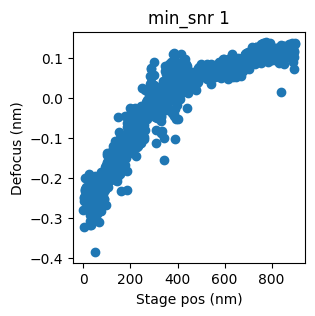

<Figure size 500x300 with 0 Axes>

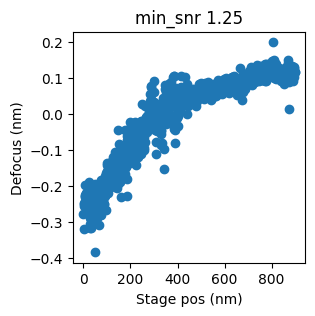

<Figure size 500x300 with 0 Axes>

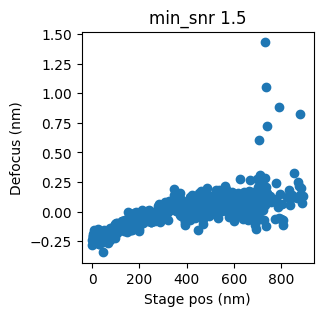

<Figure size 500x300 with 0 Axes>

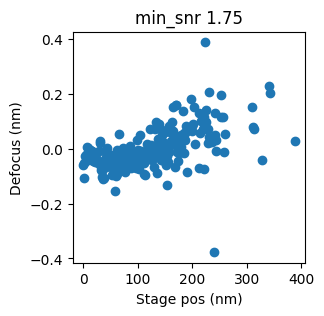

<Figure size 500x300 with 0 Axes>

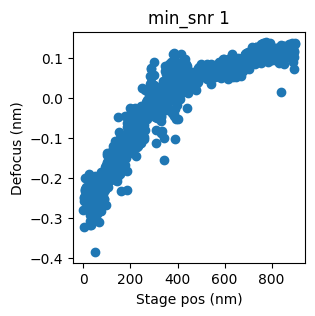

In [21]:
# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from util.util import grid_psfs
import numpy as np



xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()

def reduce_frame_planes(locs, min_snr=None):
    if min_snr is not None:
        locs = locs[locs['snr']>min_snr]
    frames = []
    pred_frame_z_init = []
    pred_frame_z_refit = []
    frame_errors = []
    n_locs_frame = []
    for frame in list(sorted(set(locs['frame']))):
        idx = np.argwhere(locs['frame']==frame).squeeze()
        if idx.size<4:
            # pred_frame_z_init.append(np.mean(pred_z[idx]))
            # pred_frame_z_refit.append(np.mean(pred_z[idx]))
            # print(f'Frame {frame} has insufficient locs')
            continue
        XY_data = xy_nm[idx]
        Z_data = pred_z.squeeze()[idx]
        reg = LinearRegression().fit(XY_data, Z_data)
              
        pred_frame_z_init.append(reg.intercept_)
    
        
        z_fit = reg.predict(XY_data)
        errors = abs(z_fit - Z_data)
        # if frame == 550:
        #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
        #     plt.show()
    
    
        # if abs(frame-50) < 10:
        #     print(reg.__dict__)
        #     x, y = np.meshgrid(np.linspace(xy_nm[:, 0].min(), xy_nm[:, 0].max(), 10), np.linspace(xy_nm[:, 1].min(), xy_nm[:, 1].max(), 10))
        #     xy2 = np.vstack((x.flatten(), y.flatten())).T
        #     z = reg.predict(XY_data)
        #     error = z-Z_data
        #     plt.figure(figsize=(3,3))
        #     plt.scatter(x=XY_data[:, 0], y=XY_data[:, 1], c=error)
        #     plt.colorbar()
        #     plt.show()
    
        idx = np.argwhere(errors<1000).squeeze()
        
        XY_data = XY_data[idx]
        Z_data = Z_data[idx]
        
        reg2 = LinearRegression().fit(XY_data, Z_data)
        
        
        residual = reg.predict(XY_data)
        res_error = np.std(residual / 1000)
    
        if len(idx) < 5:
            z = np.nan
        else:
            z = reg2.intercept_
    
        frames.append(frame)
        pred_frame_z_refit.append(z)
        frame_errors.append(res_error)
        n_locs_frame.append(len(idx))

    pred_frame_z_init = np.array(pred_frame_z_init)
    
    pred_frame_z_refit = np.array(pred_frame_z_refit)
    pred_frame_z_init = (pred_frame_z_init - np.nanmean(pred_frame_z_init)) / 1000
    
    pred_frame_z_refit_um = (pred_frame_z_refit - np.nanmean(pred_frame_z_refit)) / 1000
    frames = np.array(frames)
    errors = np.array(frame_errors)
    
    plt.figure(figsize=(5,3))
    def polyfit_1d(x, y, ax):
        idx = ~np.isnan(y)
        x2 = x[idx]
        y2 = y[idx]
        coef = np.polyfit(x2, y2, 1)
        poly1d_fn = np.poly1d(coef)
        ax.plot(x2, poly1d_fn(x2), '--', label=f'y={coef[0]:.5f}x + {coef[1]:.2f}')
        ax.legend()

    plt.figure(figsize=(3, 3))
    plt.scatter(frames, pred_frame_z_refit_um)
    plt.xlabel('Stage pos (nm)')
    plt.ylabel('Defocus (nm)')

    
    
    
    return frames, pred_frame_z_init, pred_frame_z_refit_um, errors

for min_snr in [1, 1.25, 1.5, 1.75]:
    try:
        reduce_frame_planes(locs, min_snr)
        plt.title(f'min_snr {min_snr}')
        
        plt.show()
    except Exception as e:
        print(e)


min_snr = 1
frames, pred_frame_z_init, pred_frame_z_refit_um, errors = reduce_frame_planes(locs, min_snr=min_snr)
plt.title(f'min_snr {min_snr}')
plt.show()

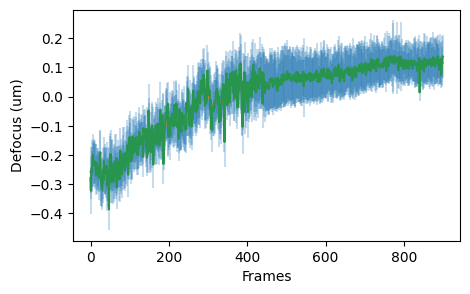

In [22]:
from scipy.stats import pearsonr

plt.figure(figsize=(5,3))


from scipy.ndimage import gaussian_filter1d

y = pred_frame_z_refit_um
smoothed_y = gaussian_filter1d(y, sigma=5)

plt.errorbar(frames, y, errors, alpha=0.25, label='stDev of residual to plane fit')
plt.plot(frames, smoothed_y)
plt.plot(frames, y)

# plt.scatter(frames, pred_frame_z_refit_um)
plt.xlabel('Frames')
plt.ylabel('Defocus (um)')
plt.show()

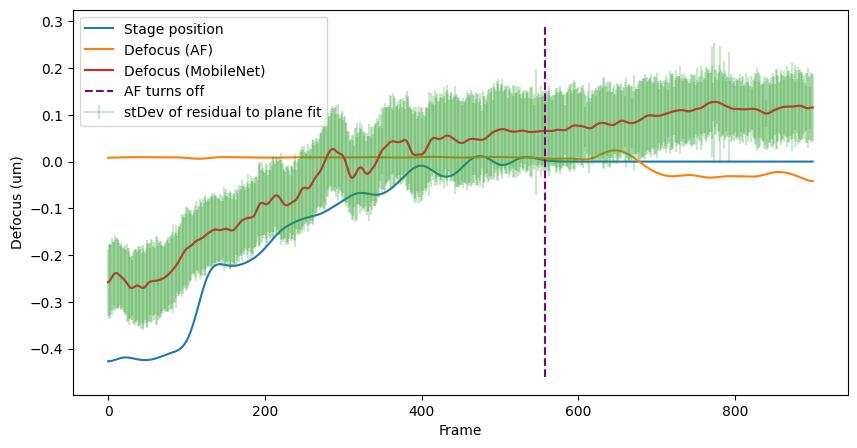

Assumptions:
	- Timelapse / AF readouts scaled to cover same duration
	- Defocus (AF) is inverted


In [23]:
import numpy as np

plt.figure(figsize=(10, 5))

comp_df = pd.read_csv(comparison_data, names=['Z drive status', 'timestamp', 'defocus', 'stage position'])
comp_df['timestamp'] = pd.to_datetime(comp_df['timestamp'], format='ISO8601')
comp_df['timestamp'] = [x.timestamp() for x in comp_df['timestamp']]
comp_df['timestamp'] -= comp_df['timestamp'][0]
comp_df['frame'] = np.linspace(0, max(frames), comp_df.shape[0])

comp_df['stage position'] -= comp_df['stage position'].to_numpy()[-1]
for c in ['stage position', 'defocus']:
    comp_df[c] = gaussian_filter1d(comp_df[c], sigma=25)

comp_df['defocus'] *= -1


# Vertical line
switch_idx = np.argwhere((comp_df['Z drive status'].to_numpy()[:-1] != comp_df['Z drive status'].to_numpy()[1:]))
switch_frame = comp_df['frame'].to_numpy()[switch_idx]
ymin = comp_df[['defocus', 'stage position']].to_numpy().min()
ymax = comp_df[['defocus', 'stage position']].to_numpy().max()

plt.plot(comp_df['frame'], comp_df['stage position'], label='Stage position')

plt.plot(comp_df['frame'], comp_df['defocus']-comp_df['defocus'].mean(), label='Defocus (AF)')

plt.errorbar(frames, smoothed_y-np.nanmean(smoothed_y), errors, alpha=0.25, label='stDev of residual to plane fit')

plt.plot(frames, smoothed_y-np.nanmean(smoothed_y), label='Defocus (MobileNet)')

ax = plt.gca()
plt.vlines([switch_frame], label='AF turns off', ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='purple', linestyle='dashed')


# plt.show()

# plt.figure(figsize=(10, 5))
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.legend()
plt.savefig(out_fig_name)
plt.show()
print('Assumptions:')
print('\t- Timelapse / AF readouts scaled to cover same duration')
print('\t- Defocus (AF) is inverted')



In [ ]:
out_fig_name

In [ ]:
# Across multiple models

from glob import glob
import h5py
import matplotlib

def snr(x):
    return x.max() / x.mean()

def eval_model_timelapse(locs_path):
    import numpy as np
    
    locs = pd.read_hdf(locs_path, key='locs')
    model_dir = os.path.join(os.path.dirname(locs_path), os.pardir, os.pardir)
    print(model_dir)
    test_fpath = os.path.join(test_data_dir, test_case)
    
    
    locs_path = test_fpath.replace('.tif', '_locs.hdf5')
    spots_path = test_fpath.replace('.tif', '_spots.hdf5')

    with h5py.File(spots_path) as f:
        spots = np.array(f['spots'])


    snrs = np.array([snr(x) for x in spots])
    inten = spots.max(axis=(1,2))
    z_pos = locs['z [nm]'].to_numpy()

    # sample = 10000
    # idx = np.random.choice(np.arange(snrs.shape[0]), 10000)
    # snrs = snrs[idx]
    # inten = inten[idx]
    # z_pos = z_pos[idx]

    # plt.scatter(inten, z_pos)
    # plt.ylabel('Z pos')
    # plt.xlabel('inten')
    # plt.show()


    
    # matplotlib.rcParams['figure.figsize'] = (5, 3)
    # fig, ax = plt.subplots()
    
    # s1 = ax.scatter(x=snrs, y=z_pos, label='snrs', marker='.', alpha=0.5)
    # ax.set_xlabel('snrs')
    # ax.set_ylabel('z pos (nm)')
    # ax2 = ax.twinx()
    # ax2.tick_params(axis='y', colors='red')
    # s2 = ax2.scatter(x=snrs, y=inten, label='inten', c='red', marker='.', alpha=0.5)
    # ax2.set_ylabel('peak pixel value (intensity)')


    # plt.title(norm)
    # ax.legend(loc=2)
    # ax2.legend(loc=1)
    # plt.show()
    # return

    # plt.figure(figsize=(10, 3))
    # sns.scatterplot(data=locs, x='frame', y='z [nm]', marker='.')
    # plt.xlabel('Frame')
    # plt.ylabel('Pred z (um)')
    # plt.show()

    # Fit plane, remove outliers and re-fit plane
    from sklearn.linear_model import LinearRegression
    import seaborn as sns
    from data.visualise import grid_psfs
    import numpy as np
    
    
    frames = []
    pred_frame_z_init = []
    pred_frame_z_refit = []
    frame_errors = []
    xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
    pred_z = locs['z [nm]'].to_numpy()
    for frame in list(sorted(set(locs['frame']))):
        idx = np.argwhere(locs['frame']==frame).squeeze()
        if idx.size<4:
            # pred_frame_z_init.append(np.mean(pred_z[idx]))
            # pred_frame_z_refit.append(np.mean(pred_z[idx]))
            # print(f'Frame {frame} has insufficient locs')
            continue
        XY_data = xy_nm[idx]
        Z_data = pred_z.squeeze()[idx]
        reg = LinearRegression().fit(XY_data, Z_data)
        pred_frame_z_init.append(reg.intercept_)
    
        
        z_fit = reg.predict(XY_data)
        errors = abs(z_fit - Z_data)
        # if frame == 550:
        #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
        #     plt.show()
        cutoff = np.percentile(errors, 75)
        idx = np.argwhere(errors<cutoff).squeeze()
        
        XY_data = XY_data[idx]
        Z_data = Z_data[idx]
        
        reg = LinearRegression().fit(XY_data, Z_data)
        residual = reg.predict(XY_data)
        res_error = np.std(residual / 1000)
        
    
        frames.append(frame)
        pred_frame_z_refit.append(reg.intercept_)
        frame_errors.append(res_error)
    
    pred_frame_z_refit_um = (pred_frame_z_refit - pred_frame_z_refit[0]) / 1000
    frames = np.array(frames)
    errors = np.array(frame_errors)

    from scipy.stats import pearsonr
    
    plt.figure(figsize=(5,3))
    
    
    from scipy.ndimage import gaussian_filter1d
    
    y = pred_frame_z_refit_um
    smoothed_y = gaussian_filter1d(y, sigma=25)
    
    plt.errorbar(frames, smoothed_y, errors, alpha=0.1, label='stDev of residual to plane fit')
    plt.plot(frames, smoothed_y)
    
    # plt.scatter(frames, pred_frame_z_refit_um)
    plt.xlabel('Frames')
    plt.ylabel('Defocus (um)')
    plt.show()

    import numpy as np

    plt.figure(figsize=(10, 5))
    
    comp_df = pd.read_csv(comparison_data, names=['Z drive status', 'timestamp', 'defocus', 'stage position'])
    comp_df['timestamp'] = pd.to_datetime(comp_df['timestamp'], format='ISO8601')
    comp_df['timestamp'] = [x.timestamp() for x in comp_df['timestamp']]
    comp_df['timestamp'] -= comp_df['timestamp'][0]
    comp_df['timestamp'] = np.linspace(0, max(frames), comp_df.shape[0])
    
    comp_df['stage position'] -= comp_df['stage position'].to_numpy()[-1]
    for c in ['stage position', 'defocus']:
        comp_df[c] = gaussian_filter1d(comp_df[c], sigma=25)
    
    comp_df['defocus'] *= -1
    for status in ['Z_ON', 'Z_OFF']:
        tmp_df = comp_df[comp_df['Z drive status']==status]
        plt.plot(tmp_df['timestamp'], tmp_df['stage position'], label=f'Stage position ({status})')
    plt.plot(frames, smoothed_y, label='Defocus (MobileNet)')
    
    
    # plt.show()
    
    # plt.figure(figsize=(10, 5))
    plt.plot(comp_df['timestamp'], comp_df['defocus'], label='Defocus (AF)')
    # plt.title(f'norm: {norm}')
    plt.xlabel('Frame')
    plt.ylabel('Defocus (um)')
    plt.legend()
    plt.show()
    print('Assumptions:')
    print('\t- Timelapse / AF readouts scaled to cover same duration')
    print('\t- Defocus (AF) is inverted')
    print(f"\t- Sum of Z preds: {pred_z.sum()}")
    # print(f"\t- norm: {norm}")
    print('-'*25)

from natsort import natsorted
loc_files = natsorted(glob('/home/miguel/Projects/smlm_z/autofocus/VIT_zeiss/*/timelapse/locs_3d.hdf5'))
for loc_file in loc_files:
    eval_model_timelapse(loc_file)

In [ ]:
frame_switch = int(np.mean(frames))

print('AF On version')
frames_on = frames[:frame_switch]
pred_frame_z_refit_on = pred_frame_z_refit_um[:frame_switch]
sns.scatterplot(x=frames_on, y=pred_frame_z_refit_on*1000, label='refit plane fit', ax=ax)
ax.set_ylabel('Defocus (um)')
ax.set_xlabel('Frame')
# ax.plot(comp_df_af_on['time stamp'], -comp_df_af_on['Defocus/um'], color='orange', label='Autofocus')
ax.legend(loc=0)
ax.legend(loc=2)
plt.show()


fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(111)

print('AF Off version')
frames_off = frames[frame_switch:]
pred_frame_z_refit_off = pred_frame_z_refit_um[frame_switch:]
sns.scatterplot(x=frames_off, y=pred_frame_z_refit_off, label='refit plane fit', ax=ax)
ax.set_ylabel('Defocus (um)')
ax.set_xlabel('Frame')
# ax.plot(comp_df_af_off['time stamp'], comp_df_af_off['Defocus/um'], color='orange', label='Autofocus')
ax.legend(loc=0)
plt.show()

In [ ]:
# Manual cutoff

onoff_cutoff = int(locs['frame'].max()/2)

# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from data.visualise import grid_psfs
import numpy as np


frames = []
pred_frame_z_init = []
pred_frame_z_refit = []
xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()
for frame in list(sorted(set(locs['frame']))):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    if idx.size<4:
        # pred_frame_z_init.append(np.mean(pred_z[idx]))
        # pred_frame_z_refit.append(np.mean(pred_z[idx]))
        print(f'Frame {frame} has insufficient locs')
        continue
    XY_data = xy_nm[idx]
    Z_data = pred_z.squeeze()[idx]
    reg = LinearRegression().fit(XY_data, Z_data)
    pred_frame_z_init.append(reg.intercept_)

    
    z_fit = reg.predict(XY_data)
    errors = abs(z_fit - Z_data)
    # if frame == 550:
    #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
    #     plt.show()
    cutoff = np.percentile(errors, 75)
    idx = np.argwhere(errors<cutoff).squeeze()
    
    XY_data = XY_data[idx]
    Z_data = Z_data[idx]
    
    reg = LinearRegression().fit(XY_data, Z_data)

    frames.append(frame)
    pred_frame_z_refit.append(reg.intercept_)

plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=frames[:onoff_cutoff], y=pred_frame_z_refit[:onoff_cutoff])
plt.title('AF on')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
sns.histplot(pred_frame_z_refit[:onoff_cutoff])
plt.title('Defocus (um) frequency while AF on')
plt.show()

plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot(x=frames[onoff_cutoff:], y=pred_frame_z_refit[onoff_cutoff:])
plt.title('AF off')
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()


In [ ]:
# Comparison without autofocus 
# Fit plane, remove outliers and re-fit plane
from sklearn.linear_model import LinearRegression
import seaborn as sns
from data.visualise import grid_psfs
import numpy as np


frames = []
pred_frame_z_init = []
pred_frame_z_refit = []
xy_nm = locs[['x [nm]', 'y [nm]']].to_numpy()
pred_z = locs['z [nm]'].to_numpy()
for frame in list(sorted(set(locs['frame']))):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    if idx.size<4:
        # pred_frame_z_init.append(np.mean(pred_z[idx]))
        # pred_frame_z_refit.append(np.mean(pred_z[idx]))
        print(f'Frame {frame} has insufficient locs')
        continue
    XY_data = xy_nm[idx]
    Z_data = pred_z.squeeze()[idx]
    reg = LinearRegression().fit(XY_data, Z_data)
    pred_frame_z_init.append(reg.intercept_)

    
    z_fit = reg.predict(XY_data)
    errors = abs(z_fit - Z_data)
    # if frame == 550:
    #     sns.scatterplot(x=XY_data[:, 0], y=XY_data[:, 1], hue=Z_data)
    #     plt.show()
    cutoff = np.percentile(errors, 75)
    idx = np.argwhere(errors<cutoff).squeeze()
    
    XY_data = XY_data[idx]
    Z_data = Z_data[idx]
    
    reg = LinearRegression().fit(XY_data, Z_data)

    frames.append(frame)
    pred_frame_z_refit.append(reg.intercept_)

pred_frame_z_refit_um = (pred_frame_z_refit - pred_frame_z_refit[0]) / 1000
frames = np.array(frames)

plt.figure(figsize=(10, 5), dpi=80)
plt.scatter(frames, pred_frame_z_refit_um)
plt.xlabel('Frame')
plt.ylabel('Defocus (um)')
plt.show()

In [ ]:

training_data = imread(os.path.join('/home/miguel/Projects/smlm_z/autofocus/VIT_autofocus2/stacks.ome.tif')).astype(float)
training_data = norm_psf_frame(training_data)


In [ ]:
# Comparison data
import numpy as np
from tifffile import imread
def get_img_gradient(img):
    return np.sum(img)
    gy, gx = np.gradient(img)
    gnorm = np.sqrt(gx**2 + gy**2)
    sharpness = np.average(gnorm)
    return sharpness

def norm_psf_frame(psfs):
    for i in range(psfs.shape[0]):
        psf_min = psfs[i].min(axis=(1,2), keepdims=True)
        psfs[i] -= psf_min
        psf_max = psfs[i].max(axis=(1,2), keepdims=True)
        psfs[i] /= psf_max
    psfs[psfs<0] = 0
    return psfs
    
def get_stack_gradient(stack):
    return np.array([get_img_gradient(s) for s in stack])

for s in training_data[0:10]:
    plt.plot(np.arange(s.shape[0])*10, get_stack_gradient(s))
plt.show()


norm_spots = norm_psf_frame(spots).squeeze()
spots_gradient = get_stack_gradient(norm_spots)

frame_grads = []
for frame in set(locs['frame']):
    idx = np.argwhere(locs['frame']==frame).squeeze()
    grads = spots_gradient[idx]
    frame_grads.append(grads)

fig, ax1 = plt.subplots()

ax1.scatter(x=frames+1, y=[np.mean(x) for x in frame_grads], label='mean gradient', color='red', marker='x')
ax1.set_ylabel('Mean of sum(gradient) in normalised images')
plt.xlabel('Frame')
# plt.show()

ax2 = ax1.twinx()
ax2.scatter(x=frames+1, y=pred_frame_z_refit, label='refit plane fit', color='blue', marker='.')
ax2.legend(loc=0)
ax1.legend(loc=2)
plt.xlabel('Frame of time-lapse')
ax2.set_ylabel('Defocus / Z position (nm)')
plt.show()

In [ ]:
frame = 550
idx = np.argwhere(locs['frame']==frame).squeeze()

XY_data = xy_nm[idx]
Z_data = pred_z.squeeze()[idx][:, np.newaxis]

print(XY_data.shape)
print(Z_data.shape)

points = np.concatenate((XY_data, Z_data), axis=1)
data_mean = np.mean(points, axis=0)
data_centered = points - data_mean
U, S, Vt = np.linalg.svd(data_centered)
normal = Vt[-1, :]
d = -np.dot(normal, data_mean)

# Calculate the plane equation coefficients
a, b, c = normal
print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=2, c='b')

# Create a meshgrid for the plane
x_plane = np.linspace(-2, 2, 100)
y_plane = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x_plane, y_plane)
Z = (-normal[0] * X - normal[1] * Y - d) / normal[2]

# Plot the plane
ax.plot_surface(X, Y, Z, alpha=0.9, color='r')

# Draw lines from the plane to each point
for point in points:
    x, y, z = point
    z_plane = (-normal[0] * x - normal[1] * y - d) / normal[2]
    ax.plot([x, x], [y, y], [z_plane, z], c='r', lw=0.5)

# Set axis labels and title
ax.set_xlabel('X (standardised)')
ax.set_ylabel('Y (standardised)')
ax.set_zlabel('Z (nm)')

# Show the plot
plt.show()